In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [ ]:
import sys
import torch
import os
from collections import Counter
import sklearn
import psutil
import numpy as np
import time
from loguru import logger

import pandas as pd
# import scanpy as sc
from tqdm import tqdm
import random

import multiprocessing
import anndata as ad
import gc
import pickle

root_path = os.path.abspath('/home/chenyx/scMulan_code/cellgpt_v1/') 
sys.path.append(os.path.abspath(root_path))

from utils.hf_tokenizer import cellGenesisTokenizer

# from imp import reload
# reload(hf_tokenizer) # also reload(mymodule)

# from utils.hf_tokenizer import cellGenesisTokenizer

data_root_path = '/nfs/public/cell_gpt_data/dataHub/datasets/datasets/' dataset = 'scMulan_ori'
dataPath = os.path.join(data_root_path,dataset)
assert os.path.exists(dataPath)
tmp_dataPath = os.path.join(dataPath,'tmp_files')

meta_info = torch.load(os.path.join(dataPath,'meta_info.pt'))
chars = meta_info['token_set']
tokenizer = cellGenesisTokenizer(chars)
n_express_level = 10

In [5]:
from multiprocessing import Pool
import multiprocessing
from tools.generation.denovoGeneration import generate_denovo

In [6]:
import scanpy as sc
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.lines as mlines
import umap

In [ ]:
def generate_combinations(base_dict, variable1_name, start_value, end_value, step):
    combinations = []
    combinations.append(base_dict)
    for value1 in range(int(start_value * 10), int((end_value + step) * 10), int(step * 10)):
        new_dict = base_dict.copy()
        new_dict[variable1_name] = value1
        combinations.append(new_dict)
    return combinations
    
def repeat_combinations(combinations, n):
    repeated_list = []
    for _ in range(n):
        repeated_list.extend(combinations)
    return repeated_list

# Process Real data

In [7]:
raw_data_path = '/nfs/public/cell_gpt_data/dataHub/datasets/datasets/ECA_GO/model_hub/bonemarrow.h5ad'
adata_origin = sc.read_h5ad(raw_data_path)

In [8]:
pd.crosstab(adata_origin.obs.study_id, adata_origin.obs.cell_type)

cell_type,B cell,Basophilic granulocyte,Common lymphoid progenitor (CLP),Erythrocyte,Erythroid progenitor cell,Granulocyte-monocyte progenitor (GMP),Haematopoietic stem and progenitor cell,Haematopoietic stem cell,Megakaryocyte,Megakaryocyte-erythrocyte progenitor (MEP),Monocyte,Multipotent lymphoid progenitor (MLP),NK T cell,Naive B cell,Neutrophilic myelocyte,Plasmacytoid dendritic cell,Pro-B cell,T cell,Unclassified
study_id,,,,,,,,,,,,,,,,,,,
10.1038/s41423-020-00574-8,0,0,0,0,0,0,0,0,0,0,0,0,8428,0,0,0,0,0,0
10.1101/2021.07.30.454542,0,2186,1058,2535,8041,9340,0,19565,907,8529,857,14950,718,0,0,4708,1639,0,10126
10.1182/blood.2019002301,0,0,2204,0,0,3073,26864,0,0,2641,0,0,0,0,0,0,0,0,0
10.1186/s13045-020-00941-y,441,0,0,0,1066,0,0,0,0,0,1303,0,0,201,6905,0,0,117,0


In [9]:
adata_origin = adata_origin[adata_origin.obs.study_id=="10.1101/2021.07.30.454542",:]
adata_origin.obs.donor_age.value_counts()

donor_age
23yr    21349
74yr    19118
72yr    17960
19yr     9525
20yr     8744
61yr     8463
Name: count, dtype: int64

In [10]:
adata_origin.obs.cell_type = adata_origin.obs.cell_type.astype(str)
adata_origin.obs.cell_type[adata_origin.obs.cell_type=="Multipotent lymphoid progenitor (MLP)"] = "Lympho-myeloid primed progenitors (LMPP)"
adata_origin = adata_origin[adata_origin.obs.donor_age.isin(['19yr']),:]
adata_origin = adata_origin[adata_origin.obs.cell_type != "Unclassified",:]
adata_origin.obs.cell_type.value_counts()

/data1/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/pandas/core/generic.py:6018: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self[name] = value
/tmp/ipykernel_3959700/1640330848.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_origin.obs.cell_type[adata_origin.obs.cell_type=="Multipotent lymphoid progenitor (MLP)"] = "Lympho-myeloid primed progenitors (LMPP)"


cell_type
Lympho-myeloid primed progenitors (LMPP)      2693
Granulocyte-monocyte progenitor (GMP)         1811
Megakaryocyte-erythrocyte progenitor (MEP)     947
Haematopoietic stem cell                       946
Erythroid progenitor cell                      890
Plasmacytoid dendritic cell                    676
Erythrocyte                                    335
Basophilic granulocyte                         278
Megakaryocyte                                  146
Monocyte                                       111
Common lymphoid progenitor (CLP)                90
NK T cell                                       26
Pro-B cell                                      17
Name: count, dtype: int64

In [ ]:
data_root_path = '/nfs/public/cell_gpt_data/dataHub/datasets/datasets/'
dataset = 'scMulan_ori'
dataPath = os.path.join(data_root_path,dataset)
assert os.path.exists(dataPath)
tmp_dataPath = os.path.join(dataPath,'tmp_files')

root_path = os.path.abspath('./cellgpt_v1/')
sys.path.append(os.path.abspath(root_path))
from utils.hf_tokenizer import cellGenesisTokenizer

meta_info = torch.load(os.path.join(dataPath,'meta_info.pt'))
chars = meta_info['token_set']
tokenizer = cellGenesisTokenizer(chars)
n_express_level = 10

In [ ]:
def get_binned_expression(row,n_expression_level):
    max_expr = row.max()
    bins = np.linspace(0, max_expr, n_expression_level + 1) 
    binned_expr = np.digitize(row, bins, right=True) 
    return pd.Series(binned_expr/n_expression_level, index=row.index)

def convert_cellsentence_ele_to_df(cellGene_ele, n_expression_level, task = 'cs'):
    dfList = []
    ## fetch gene expression
    for c,e in tqdm(cellGene_ele):
        st = c.index(2207)+1
        c_list = tokenizer.convert_ids_to_tokens(c[st:-1])
        ele = e[st:-1]
        dfDict = {}
        for name,ele in zip(c_list,ele):
            dfDict[name] = ele/n_expression_level
        dfList.append(dfDict)
    gDF = pd.DataFrame(dfList).fillna(0)
    return gDF

def format_generation_to_adata(generation_path,cell_type):
    results_save_dirs = [generation_path+res_p for res_p in os.listdir(generation_path)]
    results_save_dirs.sort()
    logger.info('working path is',generation_path)
    all_results = {'idx': [], 'cgg': [], 'cge': []}
    
    logger.info('building dataframe')
    for path in tqdm(results_save_dirs):
        results = torch.load(path)
        for key, value in results.items():
            all_results[key].extend(value)
    
    cgg = all_results['cgg']
    cge = all_results['cge']
    
    gg_len = []
    for gg in cgg:
        gg_len.append(len(gg))
    plt.hist(np.array(gg_len),bins=50,)
    
    gDF = convert_cellsentence_ele_to_df(zip(cgg,cge),n_express_level)
    origin_columns = list(meta_info['gene_set'])
    missing_columns = list(set(origin_columns) - set(gDF.columns))
    logger.debug(f'missing column number is {len(missing_columns)}')
    missing_columns_data = pd.DataFrame(0, columns=missing_columns, index=gDF.index)
    gDF = pd.concat([gDF, missing_columns_data], axis=1)
    gDF = gDF.reindex(columns=origin_columns)
    gDF.index = gDF.index.astype(str) + '_generated'
    gDF = sc.AnnData(gDF.astype(float))
    gDF.obs['cell_type'] = cell_type
    return gDF

In [13]:
#meta_info = torch.load(dataPath + '/meta_info.pt')
hvgs = meta_info['gene_set']
celldata = adata_origin[:,hvgs]
meta_sub = celldata.obs
celldataA = celldata.X.toarray()
cellDFHVG = pd.DataFrame(celldataA, columns = meta_info['gene_set'])
cellDFHVG.index = celldata.obs.index.tolist()
celldata_bin = cellDFHVG.apply(get_binned_expression, axis=1,args=(n_express_level,))
adata_real = sc.AnnData(celldata_bin.astype(float))

adata_real.obs['cell_type'] = meta_sub.cell_type
adata_real.obs['seq_tech'] = meta_sub.seq_tech
adata_real.obs['age_bin'] = meta_sub.age_bin
adata_real.obs['donor_gender'] = meta_sub.donor_gender


In [14]:
pca=PCA(n_components = 10, svd_solver='arpack',random_state=42)
X_pca = pca.fit_transform(adata_real.X)
umap_=umap.UMAP(n_neighbors=30)
proj = umap_.fit_transform(X_pca)

/data1/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


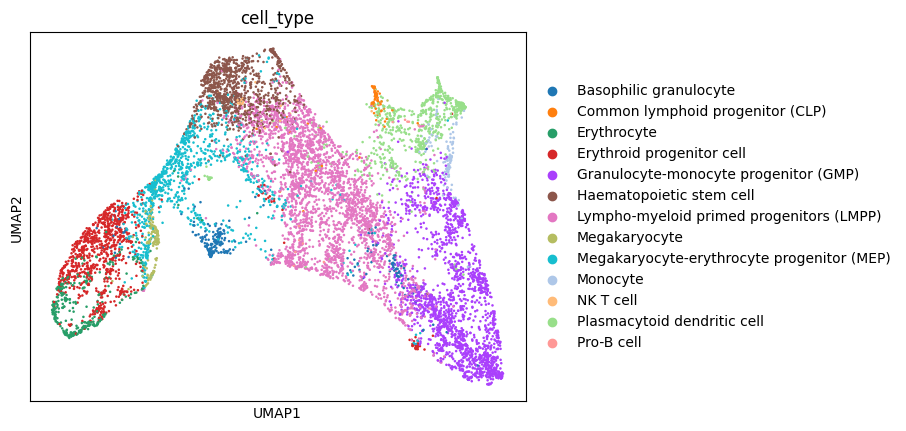

In [15]:
adata_real.obsm['X_umap'] = proj
adata_real.obsm['X_pca'] = X_pca
sc.pl.umap(adata_real,color=['cell_type'])

In [465]:
sc.pp.neighbors(adata_real,n_neighbors=30, n_pcs=10)
sc.tl.draw_graph(adata_real)

In [466]:
sc.tl.paga(adata_real, groups='cell_type')

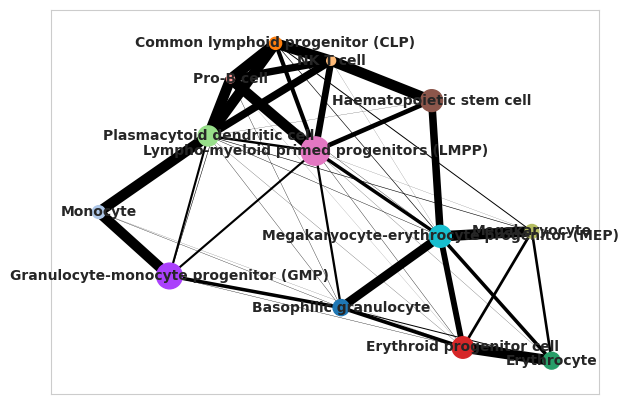

In [467]:
sc.pl.paga(adata_real, color=['cell_type'])

In [468]:
sc.tl.draw_graph(adata_real, init_pos='paga')

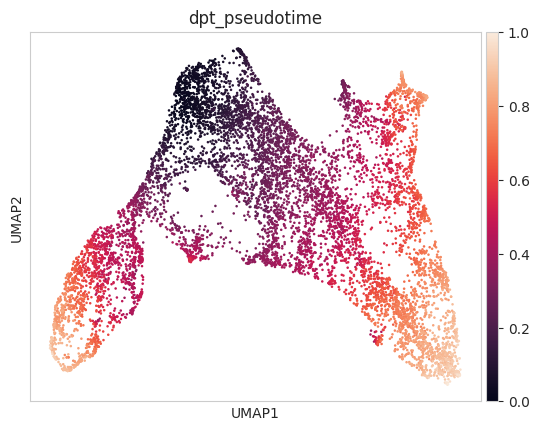

In [469]:
adata_real.uns['iroot'] = np.flatnonzero(adata_real.obs['cell_type']  == 'Haematopoietic stem cell')[0]
sc.tl.dpt(adata_real)
sc.pl.umap(adata_real,color=['dpt_pseudotime'])

In [373]:
adata_real.write_h5ad("/nfs/public/cell_gpt_data/dataHub/datasets/experiment/RealData_HSC.h5ad")

In [20]:
adata_real = sc.read_h5ad("/nfs/public/cell_gpt_data/dataHub/datasets/experiment/RealData_HSC.h5ad")

/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


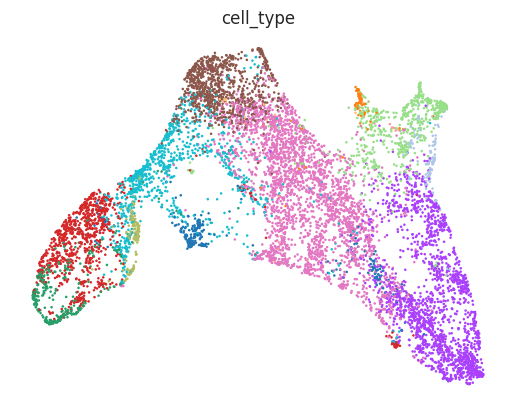

In [21]:
sc.pl.umap(adata_real,color=['cell_type'],  frameon=False, legend_loc=None, save="HSC_cell_type.pdf")

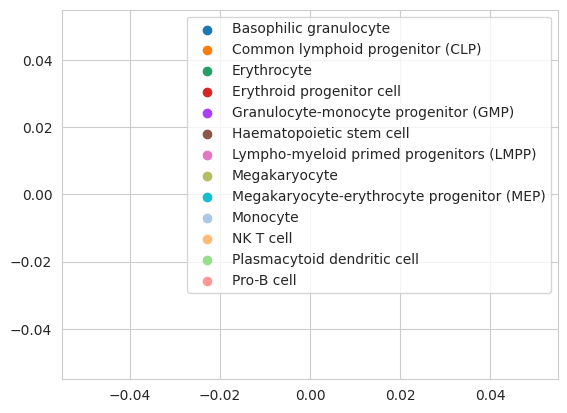

In [ ]:
plt.scatter([], [])

colors = adata_real.uns['cell_type_colors']
labels = adata_real.obs.cell_type.cat.categories

for color, label in zip(colors, labels):
    plt.scatter([], [], c=color, label=label)

plt.legend()
plt.savefig("figures/HSC_cell_type_Legend_only.pdf") 
plt.show()

# Generating data

In [113]:
def pack_arg(arg,n_process):
    return [arg for _ in range(n_process)]

## 1) SPI1

In [ ]:
base_dict = {'Bone marrow': 0, 'Haematopoietic stem cell': 0, '<SPToken1>': 0}
variable1_name = 'SPI1'
assert variable1_name in meta_info['gene_set']
start_value = 0.0
end_value = 1.0
step = 0.1

combinations = generate_combinations(base_dict, variable1_name, start_value, end_value, step)
repeat_n = 100
repeated_combinations = repeat_combinations(combinations, repeat_n)

In [ ]:
if __name__ == '__main__': 
    multiprocessing.set_start_method('spawn', force=True)
    print('当前母进程: {}'.format(os.getpid()))
    start = time.time()
    gamma = 0.1 
    use_gpu_device = [2,3] 
    n_process_in_each_gpu = 2 
    ckp_path = '/nfs/public/cell_gpt_data/dataHub/datasets/datasets/ECA_GO/model_hub/ckpt245000.pt' 
    results_dir = '/nfs/public/cell_gpt_data/dataHub/generated_cells/denovo_generation/generated_HSC_SPI1/'
    
    world_size = len(use_gpu_device)
    n_process = n_process_in_each_gpu * world_size
    process_idx = list(range(n_process))
    devices = [device for device in use_gpu_device for _ in range(n_process_in_each_gpu)]    
    print("devices: ",devices)

    if not os.path.exists(results_dir):
        os.mkdir(results_dir)
    results_save_dir = results_dir + 'generate_01gamma_' 
    meta_data_organ = None
    
    idxs = np.array_split(repeated_combinations, n_process)
    idxs = [list(idx) for idx in idxs]

    
    gammas = pack_arg(gamma,n_process)
    force_meta = pack_arg(True, n_process) 

    meta_terms = pack_arg(
         None
        ,n_process)
    
    meta_organs = pack_arg(meta_data_organ,n_process)
    
    ckp_paths = pack_arg(ckp_path,n_process)
    results_save_dirs = [results_save_dir+str(process_id)+'results.pt' for _,process_id in zip(devices,process_idx)]
    
    args = [(idx, device, gamma, meta_organ, ckp_path, save_path, meta_term, force) \
            for idx, device, gamma, meta_organ,ckp_path,save_path,meta_term, force in \
            zip(idxs, devices,gammas, meta_organs, ckp_paths,results_save_dirs,meta_terms, force_meta)]
    with Pool(n_process) as pool:
        pool.map(generate_denovo.generate, args)
            
    end = time.time()
    print("Generation Finished, 总共用时{}秒".format((end - start)))

## 2) GATA1

In [ ]:
base_dict = {'Bone marrow': 0, 'Haematopoietic stem cell': 0, '<SPToken1>': 0}
variable1_name = 'GATA1'
assert variable1_name in meta_info['gene_set']

start_value = 0.0
end_value = 1.0
step = 0.1

combinations = generate_combinations(base_dict, variable1_name, start_value, end_value, step)
repeat_n = 100
repeated_combinations = repeat_combinations(combinations, repeat_n)

In [ ]:
if __name__ == '__main__': 
    multiprocessing.set_start_method('spawn', force=True)
    print('当前母进程: {}'.format(os.getpid()))
    start = time.time()
    gamma = 0.1 
    use_gpu_device = [2,3]
    n_process_in_each_gpu = 2 
    ckp_path = '/nfs/public/cell_gpt_data/dataHub/datasets/datasets/ECA_GO/model_hub/ckpt245000.pt'
    results_dir = '/nfs/public/cell_gpt_data/dataHub/generated_cells/denovo_generation/generated_HSC_GATA1/'

    world_size = len(use_gpu_device)
    n_process = n_process_in_each_gpu * world_size
    process_idx = list(range(n_process))
    devices = [device for device in use_gpu_device for _ in range(n_process_in_each_gpu)]    
    print("devices: ",devices)

    if not os.path.exists(results_dir):
        os.mkdir(results_dir)
    results_save_dir = results_dir + 'generate_01gamma_' 
    meta_data_organ = None
    
    idxs = np.array_split(repeated_combinations, n_process) 
    idxs = [list(idx) for idx in idxs]

    
    gammas = pack_arg(gamma,n_process)
    force_meta = pack_arg(True, n_process) 

    meta_terms = pack_arg(
         None
        ,n_process)
    
    # meta_terms = pack_arg(['organ','cell_type'],n_process) # 如果不force的话
    meta_organs = pack_arg(meta_data_organ,n_process)
    
    ckp_paths = pack_arg(ckp_path,n_process)
    results_save_dirs = [results_save_dir+str(process_id)+'results.pt' for _,process_id in zip(devices,process_idx)]
    
    args = [(idx, device, gamma, meta_organ, ckp_path, save_path, meta_term, force) \
            for idx, device, gamma, meta_organ,ckp_path,save_path,meta_term, force in \
            zip(idxs, devices,gammas, meta_organs, ckp_paths,results_save_dirs,meta_terms, force_meta)]
    with Pool(n_process) as pool:
        pool.map(generate_denovo.generate, args)
            
    end = time.time()
    print("Generation Finished, 总共用时{}秒".format((end - start)))

当前母进程: 3235035
devices:  [2, 2, 3, 3]


2023-12-21 22:29:18.835 | INFO     | model.model_kvcache:__init__:252 - Current ele mode is: 1
2023-12-21 22:29:18.971 | INFO     | model.model_kvcache:__init__:252 - Current ele mode is: 1
2023-12-21 22:29:18.972 | INFO     | model.model_kvcache:__init__:252 - Current ele mode is: 1
2023-12-21 22:29:19.043 | INFO     | model.model_kvcache:__init__:252 - Current ele mode is: 1
2023-12-21 22:29:25.369 | INFO     | model.model_kvcache:__init__:291 - number of parameters: 368.80M
2023-12-21 22:29:25.443 | INFO     | model.model_kvcache:__init__:291 - number of parameters: 368.80M
2023-12-21 22:29:25.517 | INFO     | model.model_kvcache:__init__:291 - number of parameters: 368.80M
2023-12-21 22:29:25.542 | INFO     | model.model_kvcache:__init__:291 - number of parameters: 368.80M


当前子进程: 3626498
当前子进程: 3626496
当前子进程: 3626495
当前子进程: 3626497


100%|██████████| 300/300 [04:47<00:00,  1.04it/s]


Generation Finished, 总共用时303.83094668388367秒


# Process generated data

In [ ]:
data_root_path = '/nfs/public/cell_gpt_data/dataHub/datasets/datasets/'
dataset = 'scMulan_ori'
dataPath = os.path.join(data_root_path,dataset)
assert os.path.exists(dataPath)
tmp_dataPath = os.path.join(dataPath,'tmp_files')

root_path = os.path.abspath('../../../cellgpt_v1/')
sys.path.append(os.path.abspath(root_path))
from utils.hf_tokenizer import cellGenesisTokenizer

meta_info = torch.load(os.path.join(dataPath,'meta_info.pt'))
chars = meta_info['token_set']
tokenizer = cellGenesisTokenizer(chars)
n_express_level = 10

/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import tools.generation.convert_generation_to_gdata as cgdata

In [13]:
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42

In [ ]:
def get_binned_expression(row,n_expression_level):
    max_expr = row.max()
    bins = np.linspace(0, max_expr, n_expression_level + 1)
    binned_expr = np.digitize(row, bins, right=True) 
    return pd.Series(binned_expr/n_expression_level, index=row.index)

def convert_cellsentence_ele_to_df(cellGene_ele, n_expression_level, task = 'cs'):
    dfList = []
    ## fetch gene expression
    for c,e in tqdm(cellGene_ele):
        st = c.index(2207)+1
        c_list = tokenizer.convert_ids_to_tokens(c[st:-1])
        ele = e[st:-1]
        dfDict = {}
        for name,ele in zip(c_list,ele):
            dfDict[name] = ele/n_expression_level
        dfList.append(dfDict)
    gDF = pd.DataFrame(dfList).fillna(0)
    return gDF

In [ ]:
def format_generation_to_adata(generation_path,cell_type):
    results_save_dirs = [generation_path+res_p for res_p in os.listdir(generation_path)]
    results_save_dirs.sort()
    logger.info('working path is',generation_path)
    all_results = {'idx': [], 'cgg': [], 'cge': []}
    
    logger.info('building dataframe')
    for path in tqdm(results_save_dirs):
        results = torch.load(path)
        for key, value in results.items():
            all_results[key].extend(value)
    
    cgg = all_results['cgg']
    cge = all_results['cge']
    
    gg_len = []
    for gg in cgg:
        gg_len.append(len(gg))
    plt.hist(np.array(gg_len),bins=50,)
    
    gDF = convert_cellsentence_ele_to_df(zip(cgg,cge),n_express_level)
    origin_columns = list(meta_info['gene_set'])
    missing_columns = list(set(origin_columns) - set(gDF.columns))
    logger.debug(f'missing column number is {len(missing_columns)}')
    missing_columns_data = pd.DataFrame(0, columns=missing_columns, index=gDF.index)
    gDF = pd.concat([gDF, missing_columns_data], axis=1)
    gDF = gDF.reindex(columns=origin_columns)
    gDF.index = gDF.index.astype(str) + '_generated'
    gDF = sc.AnnData(gDF.astype(float))
    gDF.obs['cell_type'] = cell_type
    return gDF

In [ ]:
def generate_combinations(base_dict, variable1_name, start_value, end_value, step):
    combinations = []
    combinations.append(base_dict)
    for value1 in range(int(start_value * 10), int((end_value + step) * 10), int(step * 10)):
        new_dict = base_dict.copy()
        new_dict[variable1_name] = value1
        combinations.append(new_dict)

    return combinations

def repeat_combinations(combinations, n):
    repeated_list = []
    for _ in range(n):
        repeated_list.extend(combinations)
    return repeated_list

In [ ]:
def plot_centroids(adata, ax):
    df = pd.DataFrame({
        "UMAP_1":adata.obsm["X_umap"][:,0],
        "UMAP_2":adata.obsm["X_umap"][:,1],
        "group":adata.obs.cell_type
    })
    centroids = df.groupby('group')[['UMAP_1', 'UMAP_2']].mean()
    
    centroids['std'] = np.nan

    for group, centroid in centroids.iterrows():
        group_cells = df[df['group'] == group]
        distances = np.sqrt((group_cells['UMAP_1'] - centroid['UMAP_1'])**2 + (group_cells['UMAP_2'] - centroid['UMAP_2'])**2)
        centroids.at[group, 'STD'] = distances.std()
    
    for i in range(len(centroids.loc[:'10',:]) - 1):
        plt.plot([centroids.iloc[i]['UMAP_1'], centroids.iloc[i+1]['UMAP_1']], 
                 [centroids.iloc[i]['UMAP_2'], centroids.iloc[i+1]['UMAP_2']], 
                 color='black', linestyle='--')
        
    legend_markers = []
    for group, centroid in centroids.loc[:'10',:].iterrows():
        group_index = np.where(adata.obs.cell_type.cat.categories==group)[0][0]
        plt.scatter(centroids.loc[group,"UMAP_1"],centroids.loc[group,"UMAP_2"], marker='o', color=adata.uns['cell_type_colors'][group_index],s = 100*centroids.loc[group,"STD"]/centroids.STD.max())
        legend_markers.append(mlines.Line2D([], [], color=adata.uns['cell_type_colors'][group_index], marker='o', linestyle='None', markersize=10, label=group))


    group_index = np.where(adata.obs.cell_type.cat.categories==cell_type)[0][0]
    plt.scatter(x=centroids.loc[cell_type,"UMAP_1"], y=centroids.loc[cell_type,"UMAP_2"], marker='x', color=adata.uns['cell_type_colors'][group_index])
    legend_markers.append(mlines.Line2D([], [], color=adata.uns['cell_type_colors'][group_index], marker='x', linestyle='None', markersize=10, label=cell_type))
    
    ax.legend(handles=legend_markers, loc='upper right', bbox_to_anchor=(1.6, 1))

## 1) SPI1

### load generated data

In [15]:
generated_path = '/nfs/public/cell_gpt_data/dataHub/generated_cells/denovo_generation/generated_HSC_SPI1/'
combo_gene = "SPI1"
cell_type = 'Haematopoietic stem cell'

2024-11-12 00:40:37.974 | INFO     | tools.generation.convert_generation_to_gdata:format_generated_dict_to_adata:42 - working path is
2024-11-12 00:40:37.977 | INFO     | tools.generation.convert_generation_to_gdata:format_generated_dict_to_adata:45 - building dataframe
100%|██████████| 1200/1200 [00:00<00:00, 66659.14it/s]
2024-11-12 00:40:38.374 | DEBUG    | tools.generation.convert_generation_to_gdata:format_generated_dict_to_adata:64 - missing column number is 1324


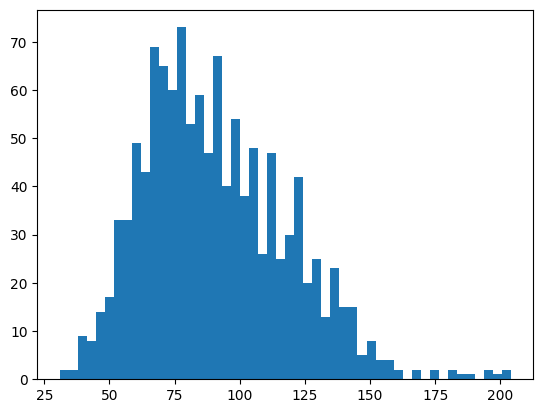

In [ ]:
adata_genrated,idxs = cgdata.format_generated_dict_to_adata(generation_path = generated_path,
                                     cell_type = cell_type,
                                     n_express_level = n_express_level,
                                     meta_info = meta_info,
                                     tokenizer = tokenizer,
                                     rename_index = False,
                                                  )

In [ ]:
filtered_indices_by_level = {i: [] for i in range(n_express_level+1)}
filtered_indices_without_key = []

for idx, combo in enumerate(idxs):
    if combo_gene in combo:
        level = combo[combo_gene]
        filtered_indices_by_level[level].append(idx)
    else:
        filtered_indices_without_key.append(idx)


adata_genrated_filtered_without_key = adata_genrated[filtered_indices_without_key]
adata_genrated_filtered_array_without_key = adata_genrated_filtered_without_key.X.toarray()

for level, indices in filtered_indices_by_level.items():
    adata_genrated_filtered = adata_genrated[indices]
    adata_genrated_filtered_array = adata_genrated_filtered.X.toarray()      
    
labels = ['GS'] + [str(i) for i in range(n_express_level+1)]

for k,v in tqdm(filtered_indices_by_level.items()):
    adata_genrated.obs.cell_type[v] = str(k)
    
adata_genrated.obs.cell_type[filtered_indices_without_key] = cell_type

100%|██████████| 11/11 [00:00<00:00, 3959.61it/s]


In [482]:
X_pca = pca.transform(adata_genrated.X)
X_umap = umap_.transform(X_pca)

adata_genrated.obsm['X_umap'] = X_umap

### visualization

In [18]:
sns.set_style("whitegrid")
related_cell_types = ['Haematopoietic stem cell','Lympho-myeloid primed progenitors (LMPP)', 'Granulocyte-monocyte progenitor (GMP)','Monocyte','Plasmacytoid dendritic cell']

In [24]:
adata_real.obs['related'] = adata_real.obs['cell_type'].astype(str)
adata_real.obs['related'][-adata_real.obs.cell_type.isin(related_cell_types)] = "Not-related"
adata_real.obs.related = pd.Categorical(adata_real.obs.related)
adata_real.uns['related_colors'] = ["#666666" for _ in adata_real.obs['related'].unique()]
adata_real.obs.cell_type = pd.Categorical(adata_real.obs.cell_type)
for ct in adata_real.obs['related'].unique():
    if ct != 'Not-related':
        ct_index = np.where(adata_real.obs.cell_type.cat.categories==ct)[0][0]
        r_index = np.where(adata_real.obs.related.cat.categories==ct)[0][0]
        adata_real.uns['related_colors'][r_index] = adata_real.uns['cell_type_colors'][ct_index]

/tmp/ipykernel_818025/2024866455.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata_real.obs['related'][-adata_real.obs.cell_type.isin(related_cell_types)] = "Not-related"
/tmp/ipykernel_818025/2024866455.py:2: SettingWithCopyWarning:

/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values

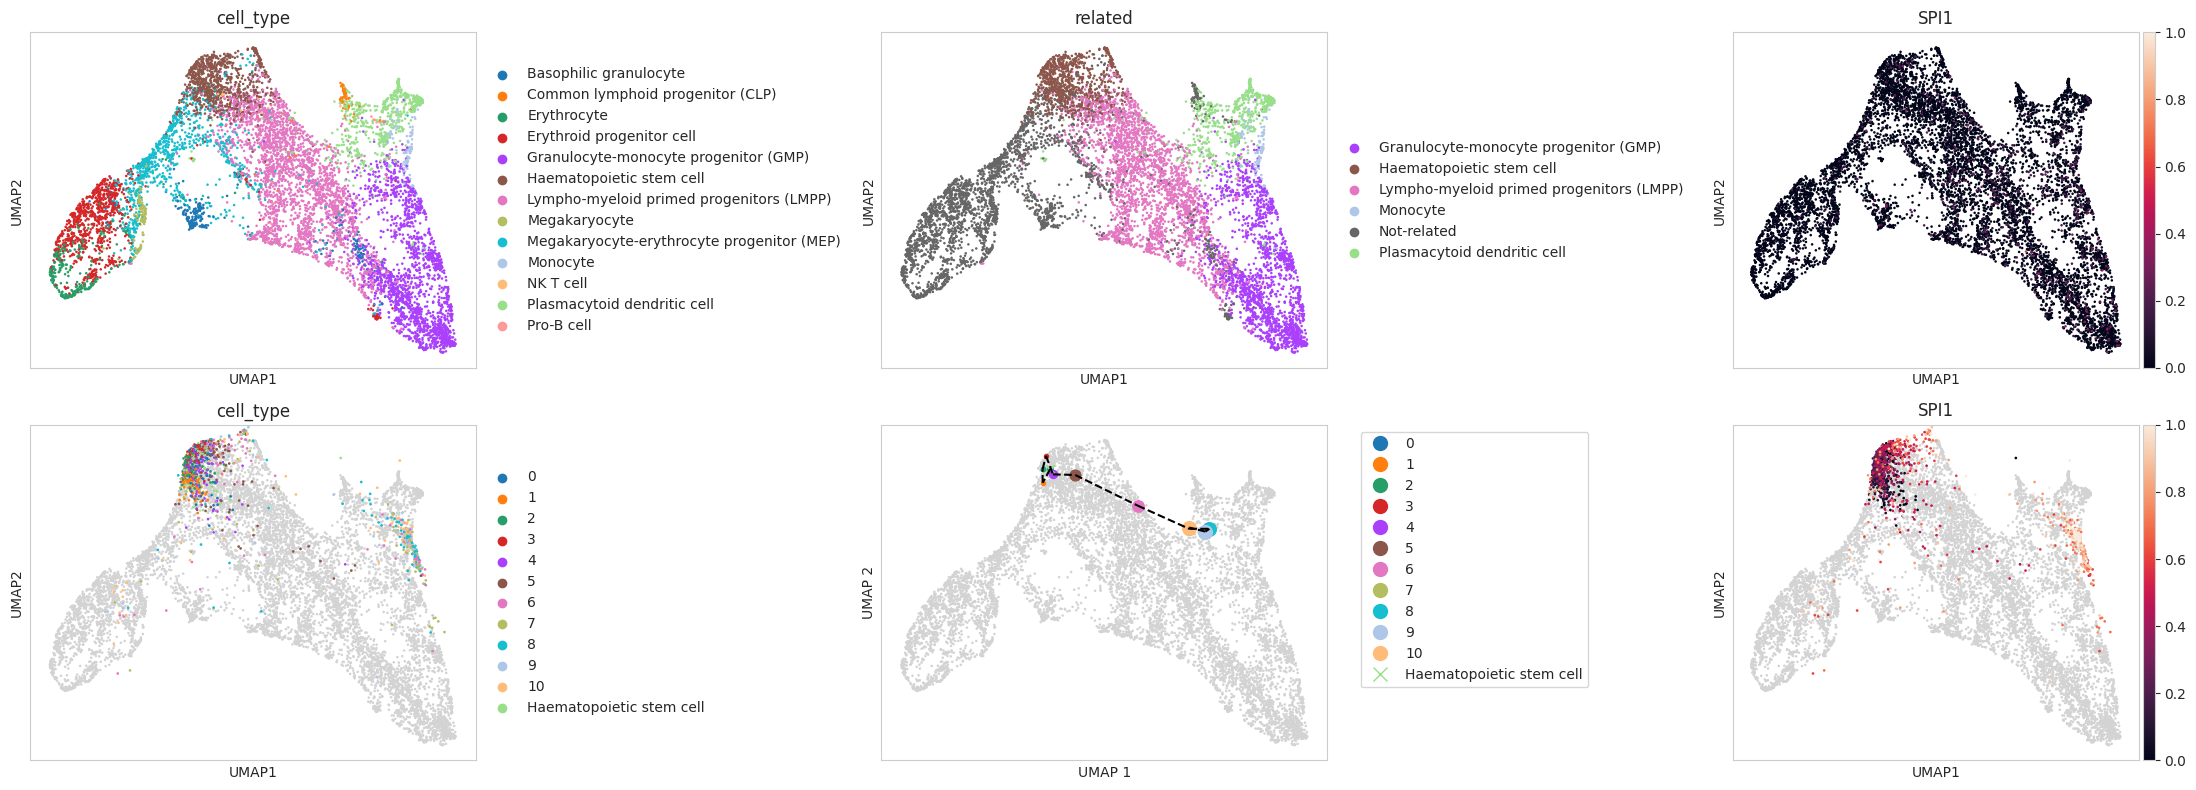

In [ ]:
fig=plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(2, 3, 1)
sc.pl.umap(adata_real,color=["cell_type"], ax=ax1, show=False,)

ax2 = fig.add_subplot(2, 3, 2)
sc.pl.umap(adata_real,color=["related"], ax=ax2, show=False,)
lim1_y,lim1_x,lim2_y,lim2_x=ax2.get_ylim()[0],ax2.get_xlim()[0],ax2.get_ylim()[1],ax2.get_xlim()[1]

ax3 = fig.add_subplot(2, 3, 3) 
sc.pl.umap(adata_real,color=[combo_gene], ax=ax3, show=False, vmin=0, vmax=1)

ax4 = fig.add_subplot(2, 3, 4)
sc.pl.umap(adata_real, ax=ax4, show=False)
sc.pl.umap(adata_genrated,color=["cell_type"], ax=ax4, show=False,size=15) 
ax4.set_xlim(lim1_x,lim2_x)
ax4.set_ylim(lim1_y,lim2_y)

ax5 = fig.add_subplot(2, 3, 5)
sc.pl.umap(adata_real, ax=ax5, show=False)
plot_centroids(adata_genrated,ax5)

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
ax5.set_xlim(lim1_x,lim2_x)
ax5.set_ylim(lim1_y,lim2_y)
ax5.grid(False)


ax6 = fig.add_subplot(2, 3, 6)
sc.pl.umap(adata_real, ax=ax6, show=False)
sc.pl.umap(adata_genrated,color=[combo_gene], ax=ax6, show=False,size=15, vmin=0, vmax=1) # 这里把点画大一点好看
ax6.set_xlim(lim1_x,lim2_x)
ax6.set_ylim(lim1_y,lim2_y)

plt.tight_layout() 
plt.savefig("figures/FigS12_SPI.pdf")
plt.show()

In [486]:
adata_genrated.write_h5ad("/nfs/public/cell_gpt_data/dataHub/generated_cells/denovo_generation/generated_HSC_SPI1.h5ad")

## 2) GATA1

### load generated data

In [503]:
generated_path = '/nfs/public/cell_gpt_data/dataHub/generated_cells/denovo_generation/generated_HSC_GATA1/'
combo_gene = "GATA1"
cell_type = 'Haematopoietic stem cell'

2023-12-22 15:26:59.258 | INFO     | tools.generation.convert_generation_to_gdata:format_generated_dict_to_adata:42 - working path is
2023-12-22 15:26:59.259 | INFO     | tools.generation.convert_generation_to_gdata:format_generated_dict_to_adata:45 - building dataframe
100%|██████████| 1200/1200 [00:00<00:00, 88644.83it/s]
2023-12-22 15:26:59.409 | DEBUG    | tools.generation.convert_generation_to_gdata:format_generated_dict_to_adata:64 - missing column number is 1410


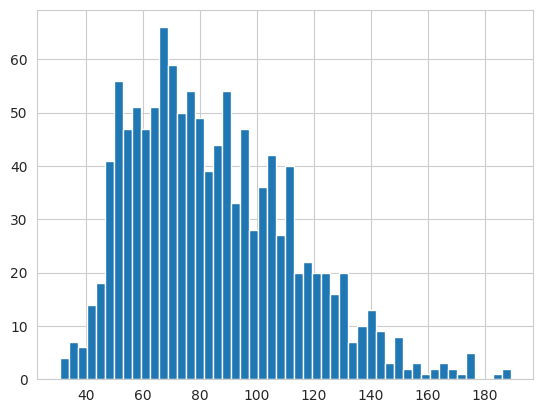

In [ ]:
adata_genrated,idxs = cgdata.format_generated_dict_to_adata(generation_path = generated_path,
                                     cell_type = cell_type, 
                                     n_express_level = n_express_level,
                                     meta_info = meta_info,
                                     tokenizer = tokenizer,
                                     rename_index = False,
                                                  )

In [ ]:
filtered_indices_by_level = {i: [] for i in range(n_express_level+1)}
filtered_indices_without_key = []

for idx, combo in enumerate(idxs):
    if combo_gene in combo:
        level = combo[combo_gene]
        filtered_indices_by_level[level].append(idx)
    else:
        filtered_indices_without_key.append(idx)


adata_genrated_filtered_without_key = adata_genrated[filtered_indices_without_key]
adata_genrated_filtered_array_without_key = adata_genrated_filtered_without_key.X.toarray()

for level, indices in filtered_indices_by_level.items():
    adata_genrated_filtered = adata_genrated[indices]
    adata_genrated_filtered_array = adata_genrated_filtered.X.toarray()      

labels = ['GS'] + [str(i) for i in range(n_express_level+1)]

for k,v in tqdm(filtered_indices_by_level.items()):
    adata_genrated.obs.cell_type[v] = str(k)
    
adata_genrated.obs.cell_type[filtered_indices_without_key] = cell_type

100%|██████████| 11/11 [00:00<00:00, 6994.75it/s]


In [506]:
X_pca = pca.transform(adata_genrated.X)
X_umap = umap_.transform(X_pca)

adata_genrated.obsm['X_umap'] = X_umap

### visualization

In [28]:
sns.set_style("whitegrid")
related_cell_types = ['Haematopoietic stem cell','Megakaryocyte-erythrocyte progenitor (MEP)','Erythroid progenitor cell','Megakaryocyte','Erythroid progenitor cell','Erythrocyte']

In [29]:
adata_real.obs['related'] = adata_real.obs['cell_type'].astype(str)
adata_real.obs['related'][-adata_real.obs.cell_type.isin(related_cell_types)] = "Not-related"
adata_real.obs.related = pd.Categorical(adata_real.obs.related)
adata_real.uns['related_colors'] = ["#666666" for _ in adata_real.obs['related'].unique()]
adata_real.obs.cell_type = pd.Categorical(adata_real.obs.cell_type)
for ct in adata_real.obs['related'].unique():
    if ct != 'Not-related':
        ct_index = np.where(adata_real.obs.cell_type.cat.categories==ct)[0][0]
        r_index = np.where(adata_real.obs.related.cat.categories==ct)[0][0]
        adata_real.uns['related_colors'][r_index] = adata_real.uns['cell_type_colors'][ct_index]

/tmp/ipykernel_818025/2024866455.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata_real.obs['related'][-adata_real.obs.cell_type.isin(related_cell_types)] = "Not-related"
/tmp/ipykernel_818025/2024866455.py:2: SettingWithCopyWarning:

/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values

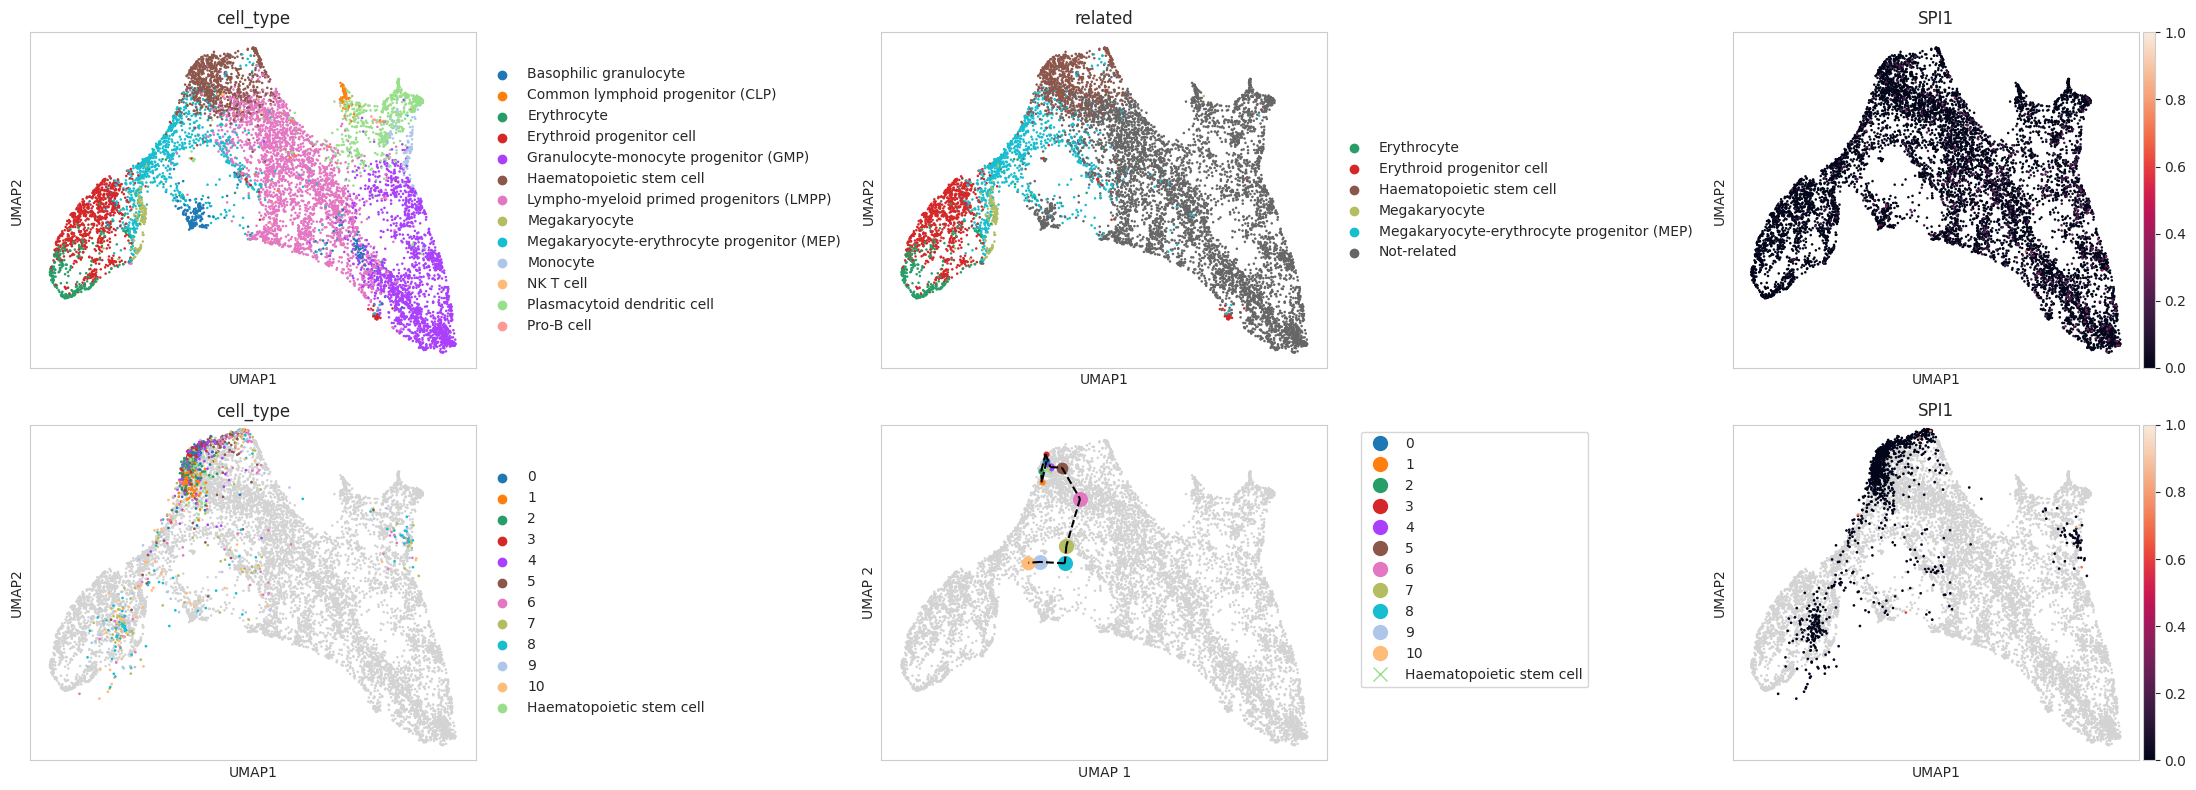

In [ ]:
fig=plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(2, 3, 1) 
sc.pl.umap(adata_real,color=["cell_type"], ax=ax1, show=False,)

ax2 = fig.add_subplot(2, 3, 2)
sc.pl.umap(adata_real,color=["related"], ax=ax2, show=False,)
lim1_y,lim1_x,lim2_y,lim2_x=ax2.get_ylim()[0],ax2.get_xlim()[0],ax2.get_ylim()[1],ax2.get_xlim()[1]

ax3 = fig.add_subplot(2, 3, 3) 
sc.pl.umap(adata_real,color=[combo_gene], ax=ax3, show=False, vmin=0, vmax=1)

ax4 = fig.add_subplot(2, 3, 4)
sc.pl.umap(adata_real, ax=ax4, show=False)
sc.pl.umap(adata_genrated,color=["cell_type"], ax=ax4, show=False,size=15) 
ax4.set_xlim(lim1_x,lim2_x)
ax4.set_ylim(lim1_y,lim2_y)

ax5 = fig.add_subplot(2, 3, 5)
sc.pl.umap(adata_real, ax=ax5, show=False)
plot_centroids(adata_genrated,ax5)


plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
ax5.set_xlim(lim1_x,lim2_x)
ax5.set_ylim(lim1_y,lim2_y)
ax5.grid(False)


ax6 = fig.add_subplot(2, 3, 6)
sc.pl.umap(adata_real, ax=ax6, show=False)
sc.pl.umap(adata_genrated,color=[combo_gene], ax=ax6, show=False,size=15, vmin=0, vmax=1) 
ax6.set_xlim(lim1_x,lim2_x)
ax6.set_ylim(lim1_y,lim2_y)

plt.tight_layout() 
plt.savefig("figures/FigS12_GATA1.pdf")
plt.show()

In [510]:
adata_genrated.write_h5ad("/nfs/public/cell_gpt_data/dataHub/generated_cells/denovo_generation/generated_HSC_GATA1.h5ad")